In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, multivariate_normal, uniform
from scipy.special import loggamma
import emcee
import corner

In [2]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
alpha = 0.121851859725
beta = 2.46569277393
delta = -0.0363405630486
print(SCP_data)

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [3]:
filename = 'SCPUnion2.1_mu_vs_z.txt'

# Load the data from the file
data = np.loadtxt(filename, usecols=(1, 2, 3, 4), skiprows = 5)

z = data[:, 0] # size: 580x1
low = z < 0.5
mu = data[:, 1]
mu_error = data[:, 2]
P_low_mass = data[:, 3]
dl = 10**(mu/5-5)
#dl_error = dl*mu_error/5
dl_error = 10**(mu/5-5)*(10**(mu_error/5) - 1)

low_z = z[low] # size: 412x1
low_mu = mu[low]
low_mu_error = mu_error[low]
low_P_low_mass = P_low_mass[low]
low_dl = 10**(low_mu/5-5)
#find correct expression
#low_dl_error = 10**(low_mu_error/5-5)
low_dl_error = dl_error[low]

In [4]:
def log_likelihood(theta, phi, data, weights, error_scale):
    mat = np.matmul(phi,theta)-data
    return -0.5*np.matmul(np.matmul(np.transpose(mat), weights),mat)/error_scale

def log_prior(theta, alpha, beta):
    #uniform prior
    return 0
def log_posterior(theta, phi, data, weights, error_scale):
    ll = log_likelihood(theta, phi, data, weights, error_scale)
    lp = log_prior(theta)
    return ll + lp


In [18]:
low_phi = np.transpose(np.array([low_z, low_z**2]))
weights =  np.diag(1/low_dl_error) #np.diag(np.ones(len(low_dl_error)))#
weights = len(low_dl)*weights/np.sum(weights)
error_scale = beta/(alpha+1)

nwalkers = 20
ndim = 2
start = np.random.randn(nwalkers,ndim) + 1000
print(start.shape)
print(low_phi.shape)
print(weights.shape)
#print((low_phi*start).shape)

#res = log_likelihood(start, low_phi, low_dl, weights, error_scale)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(low_phi, low_dl, weights, error_scale))
sampler.run_mcmc(start, 2000, progress=True)

(20, 2)
(412, 2)
(412, 412)


100%|██████████| 2000/2000 [00:03<00:00, 573.69it/s]


State([[4308.12371632 2978.21593585]
 [4303.15956187 2998.51479208]
 [4307.06138048 2983.88344059]
 [4304.33637621 2993.52050415]
 [4309.49788276 2982.76795452]
 [4305.82857008 2987.76375929]
 [4307.50118019 2988.92607257]
 [4307.50680781 2980.89407126]
 [4306.53468207 2987.00656931]
 [4306.62521682 2990.34002178]
 [4304.91116967 2992.64741052]
 [4310.18121514 2976.70373999]
 [4308.42317259 2981.42727697]
 [4309.07827715 2979.94975555]
 [4305.63471775 2992.15247153]
 [4306.42139898 2985.29334406]
 [4307.9629405  2983.68161171]
 [4307.81313267 2985.9719964 ]
 [4307.23917076 2983.54027402]
 [4307.75145564 2983.69466113]], log_prob=[-174597.15292659 -174597.49738811 -174595.60995611 -174596.30586829
 -174597.44647567 -174595.72301907 -174596.73665276 -174596.42703846
 -174595.31452136 -174596.03893844 -174595.90180834 -174596.77913747
 -174595.59707175 -174595.91742148 -174595.84284218 -174595.82696523
 -174595.42001244 -174595.75745342 -174595.56252053 -174595.35913865], blobs=None, rand

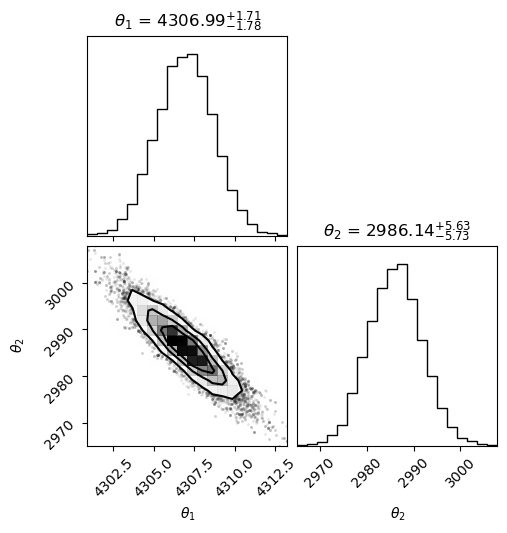

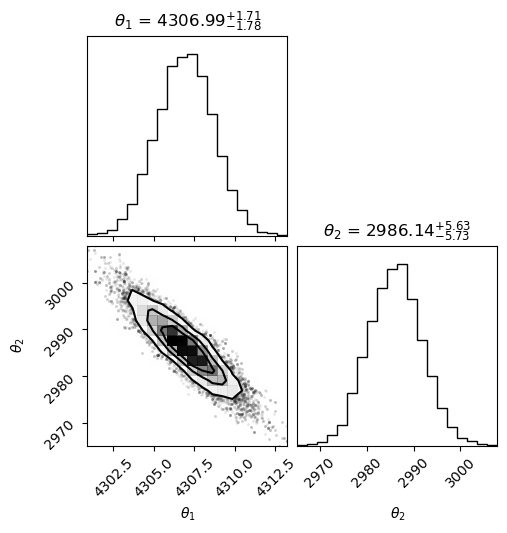

In [19]:
burn_in = 1000
flat_mcmc_samples = sampler.get_chain(discard=burn_in, flat=True)
corner.corner(flat_mcmc_samples, labels = [r"$\theta_1$", r"$\theta_2$"], show_titles = True)

In [20]:
print(flat_mcmc_samples.shape)
c = 300000 #km/s
theta_1 = flat_mcmc_samples[:,0]
theta_2 = flat_mcmc_samples[:,1]
H_0 = c/theta_1
q_0 = 1-2*H_0*theta_2/c
print(f"H_0 = {np.mean(H_0)}\n q_0 = {np.mean(q_0)}")

(20000, 2)
H_0 = 69.65463538725506
 q_0 = -0.3866574460990676


226.25547703303658
226.23786024159205
226.27272971048177


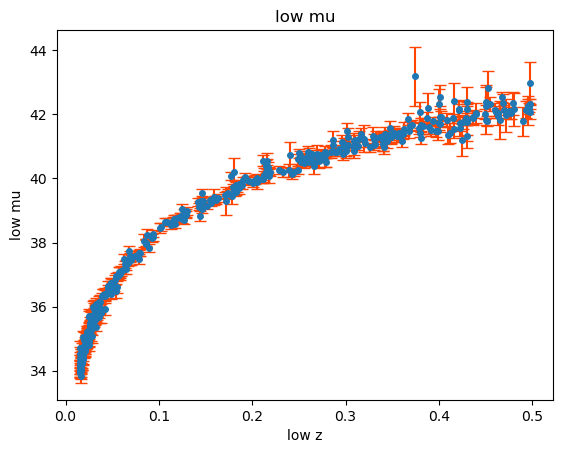

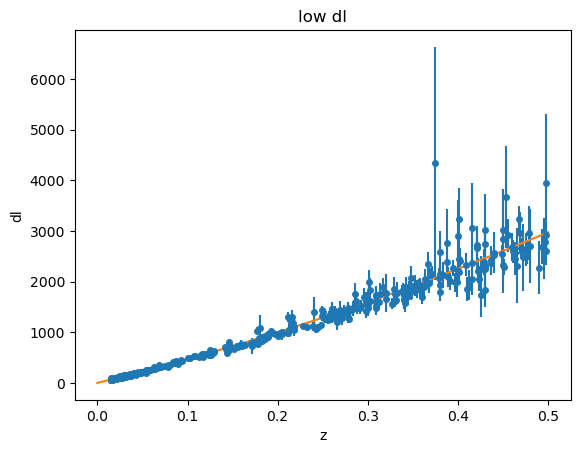

In [14]:
z_lin = np.linspace(0,0.5, 1000)
res_d = np.empty(1000)
res_d_min = np.empty(1000)
res_d_max = np.empty(1000)
for i,z in enumerate(z_lin):
    vec = theta_1 * z + theta_2 * z**2
    res_d[i] = np.mean(vec)
    res_d_min[i] = np.percentile(vec, 30)
    res_d_max[i] = np.percentile(vec,70)

print(res_d[100])
print(res_d_min[100])
print(res_d_max[100])

plt.figure(1)
plt.errorbar(low_z, low_mu, yerr=low_mu_error, fmt='o', ecolor='orangered', capsize=4, linestyle='None', markersize=4)
plt.xlabel('low z')
plt.ylabel('low mu')
plt.title('low mu')

# Display the first figure
plt.show()

# Create the second figure with error bars
plt.figure(2)
plt.errorbar(low_z, low_dl, yerr = low_dl_error, fmt = 'o', markersize=4)
plt.plot(z_lin, res_d)
plt.fill_between(z_lin, res_d_min, res_d_max, alpha = 0.4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('low dl')

# Display the second figure
plt.show()